In [15]:
import tensorflow as tf
import pandas as pd
import numpy as np
import sys
import os
import librosa
import librosa.display
# import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

In [16]:
Emotions = pd.read_csv('/kaggle/input/new-data/emotion4.csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,1611,1612,1613,1614,1615,1616,1617,1618,1619,Emotions
0,0.055176,0.095215,0.160156,0.213867,0.262207,0.312500,0.348145,0.361328,0.365234,0.349121,...,1.017847,1.011451,1.003673,0.994527,0.984050,0.972249,0.959179,0.944863,0.929345,sad
1,0.113281,0.181641,0.273926,0.316406,0.345215,0.370117,0.375488,0.372070,0.370117,0.382324,...,3.387598,4.066836,6.973920,2.352084,2.447948,-0.956190,4.410006,2.127808,0.108541,sad
2,0.034180,0.066406,0.130371,0.196289,0.271484,0.328613,0.368652,0.388184,0.382812,0.373535,...,1.705197,1.698357,1.690013,1.680189,1.668895,1.656147,1.641968,1.626385,1.609414,sad
3,0.073242,0.120117,0.188965,0.254883,0.305176,0.351074,0.387207,0.396484,0.398438,0.402344,...,0.031623,0.044344,5.272876,3.203002,0.495236,-1.108803,0.711020,7.512552,3.949652,sad
4,0.000000,0.000000,0.000000,0.006836,0.006836,0.006836,0.083496,0.076660,0.076660,0.076660,...,16.396500,13.472528,10.924034,6.113907,0.031529,8.286678,14.161294,9.829187,1.385454,calm


In [17]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
1616        False
1617        False
1618        False
1619        False
Emotions    False
Length: 1621, dtype: bool


(48648, 1621)

In [18]:
X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [19]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [20]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38918, 1620), (38918, 8), (9730, 1620), (9730, 8))

In [21]:
# #reshape for lstm
# X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
# X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [22]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38918, 1620), (38918, 8), (9730, 1620), (9730, 8))

In [23]:
# scaling our data with sklearn's Standard scaler
# scaler = StandardScaler()
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.transform(x_test)
# x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [24]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau


early_stop = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1,restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, factor=0.5, min_lr=0.00001, mode='max', verbose=1)
model_checkpoint = ModelCheckpoint('best_model1_weights.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [25]:
x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape

((38918, 1620, 1), (38918, 8), (9730, 1620, 1), (9730, 8))

In [26]:
import tensorflow.keras.layers as L

model = tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(x_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    
    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),
    
    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    
    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  
    
    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.2), 
    
    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(8,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()



/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 1620, 512)      │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1620, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 810, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 810, 512)       │     1,311,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 810, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 405, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 405, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 405, 256)       │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 405, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 203, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 203, 256)       │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 203, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 102, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 102, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 102, 128)       │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 102, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 51, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 51, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6528)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     3,342,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         4,10

 Total params: 5,620,872 (21.44 MB)

 Trainable params: 5,616,520 (21.43 MB)

 Non-trainable params: 4,352 (17.00 KB)

In [27]:
history=model.fit(x_traincnn, y_train, epochs=50, validation_data=(x_testcnn, y_test), batch_size=32,callbacks=[early_stop,lr_reduction,model_checkpoint])

Epoch 1/50
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.4080 - loss: 1.6545

W0000 00:00:1720656001.459744     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.48016, saving model to best_model1_weights.keras


/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


1217/1217 ━━━━━━━━━━━━━━━━━━━━ 86s 62ms/step - accuracy: 0.4080 - loss: 1.6543 - val_accuracy: 0.4802 - val_loss: 1.3907 - learning_rate: 0.0010
Epoch 2/50
1216/1217 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5304 - loss: 1.2316
Epoch 2: val_accuracy did not improve from 0.48016
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 68s 56ms/step - accuracy: 0.5304 - loss: 1.2315 - val_accuracy: 0.4394 - val_loss: 1.5723 - learning_rate: 0.0010
Epoch 3/50
1216/1217 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5693 - loss: 1.1185
Epoch 3: val_accuracy improved from 0.48016 to 0.58181, saving model to best_model1_weights.keras
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 68s 56ms/step - accuracy: 0.5693 - loss: 1.1184 - val_accuracy: 0.5818 - val_loss: 1.0805 - learning_rate: 0.0010
Epoch 4/50
1216/1217 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6100 - loss: 1.0232
Epoch 4: val_accuracy improved from 0.58181 to 0.59640, saving model to best_model1_weights.keras
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 68s 56ms/step - accu

305/305 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9723 - loss: 0.1060
Accuracy of our model on test data :  97.28674292564392 %


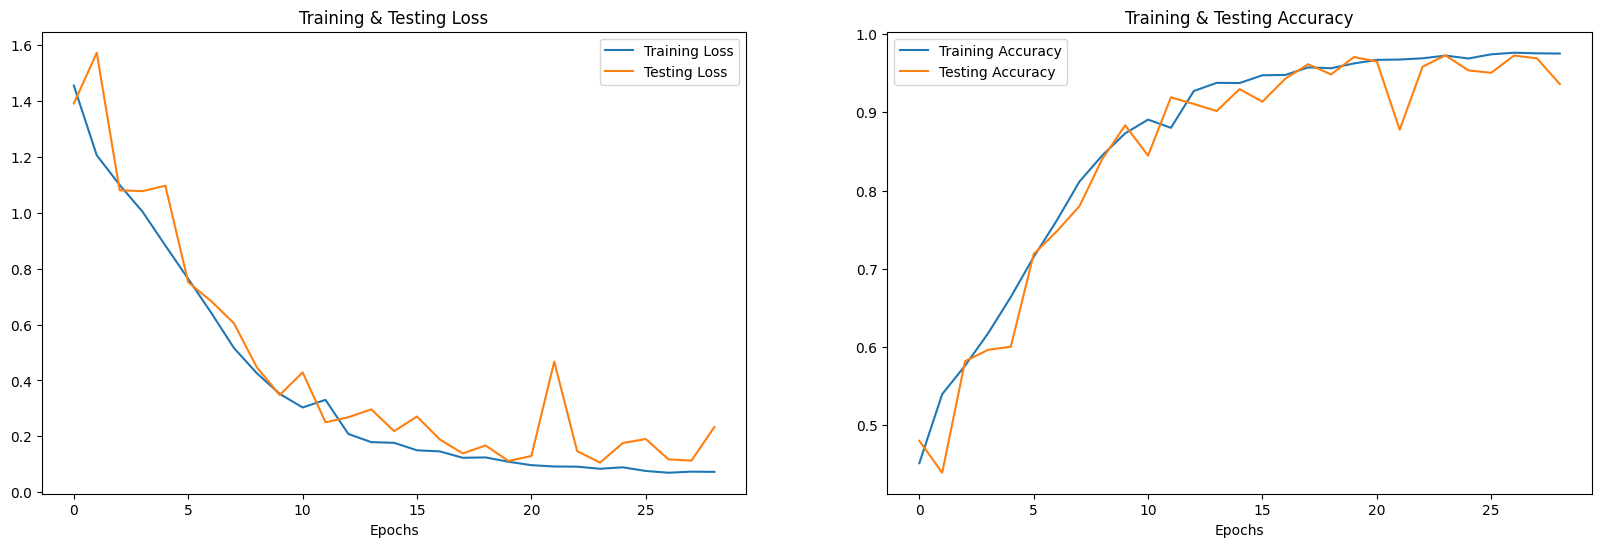

In [28]:
print("Accuracy of our model on test data : ", model.evaluate(x_testcnn, y_test)[1] * 100, "%")

epochs = [i for i in range(len(history.history['loss']))]
fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20, 6)
ax[0].plot(epochs, train_loss, label='Training Loss')
ax[0].plot(epochs, test_loss, label='Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs, train_acc, label='Training Accuracy')
ax[1].plot(epochs, test_acc, label='Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()


In [29]:
# predicting on test data.
pred_test0 = model.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

df0.head(10)

305/305 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


,Predicted Labels,Actual Labels
0,fear,fear
1,disgust,disgust
2,disgust,disgust
3,neutral,neutral
4,sad,sad
5,neutral,neutral
6,sad,sad
7,happy,happy
8,angry,angry
9,neutral,neutral


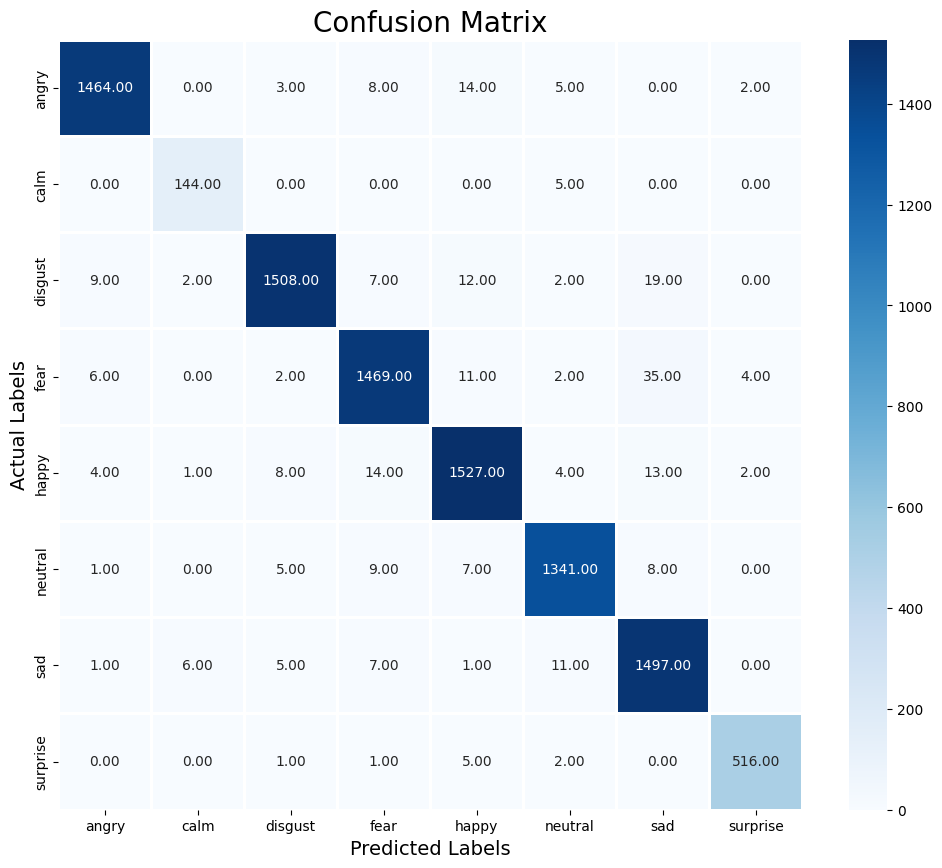

              precision    recall  f1-score   support

       angry       0.99      0.98      0.98      1496
        calm       0.94      0.97      0.95       149
     disgust       0.98      0.97      0.98      1559
        fear       0.97      0.96      0.97      1529
       happy       0.97      0.97      0.97      1573
     neutral       0.98      0.98      0.98      1371
         sad       0.95      0.98      0.97      1528
    surprise       0.98      0.98      0.98       525

    accuracy                           0.97      9730
   macro avg       0.97      0.97      0.97      9730
weighted avg       0.97      0.97      0.97      9730



In [30]:
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test0, y_pred0)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test0, y_pred0))

In [50]:
from tensorflow.keras.models import Sequential, model_from_json

# Serialize model to JSON
model_json = model.to_json()
with open("CNN_model.json", "w") as json_file:
    json_file.write(model_json)

# Serialize weights to HDF5
model.save_weights("newmodel.weights.h5")
print("Saved model to disk")


Saved model to disk


In [32]:
from tensorflow.keras.models import Sequential, model_from_json
json_file = open('/kaggle/working/CNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/kaggle/working/CNN_model_weights.weights.h5")
print("Loaded model from disk")

Loaded model from disk


In [33]:
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn,y_test)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

305/305 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9723 - loss: 0.1060
compile_metrics: 97.29%


In [34]:
import pickle

# Saving scaler
with open('scaler2.pickle', 'wb') as f:
    pickle.dump(scaler, f)

# Loading scaler
with open('scaler2.pickle', 'rb') as f:
    scaler2 = pickle.load(f)

# Saving encoder
with open('encoder2.pickle', 'wb') as f:
    pickle.dump(encoder, f)

# Loading encoder
with open('encoder2.pickle', 'rb') as f:
    encoder2 = pickle.load(f)

    
print("Done")    

Done


In [35]:
from tensorflow.keras.models import Sequential, model_from_json
json_file = open('/kaggle/working/CNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/kaggle/working/CNN_model_weights.h5")
print("Loaded model from disk")

Loaded model from disk


In [36]:
import pickle

with open('/kaggle/working/scaler2.pickle', 'rb') as f:
    scaler2 = pickle.load(f)
    
with open('/kaggle/working/encoder2.pickle', 'rb') as f:
    encoder2 = pickle.load(f)

    
print("Done")

Done


In [41]:
import librosa
import resampy

def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)


def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)

def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13, hop_length=hop_length)
    return np.squeeze(mfcc.T) if not flatten else np.ravel(mfcc.T)

def extract_features(data, sr=22050, frame_length=2048, hop_length=512):
    # Extract individual features
    zcr_result = zcr(data, frame_length, hop_length)
    rmse_result = rmse(data, frame_length, hop_length)
    mfcc_result = mfcc(data, sr, frame_length, hop_length, flatten=True)  # Ensure mfcc is flattened
    
    # Concatenate features
    combined_features = np.hstack((zcr_result, rmse_result, mfcc_result))
    
    # Check total size
    total_features = len(combined_features)
    
    # Pad or truncate to ensure exactly 1620 features
    if total_features < 1620:
        combined_features = np.pad(combined_features, (0, 1620 - total_features), mode='constant')
    elif total_features > 1620:
        combined_features = combined_features[:1620]
    
    # Reshape to (1, 1620)
    combined_features = np.reshape(combined_features, newshape=(1, 1620))
    
    return combined_features

In [42]:
def get_predict_feat(path):
    d, s_rate= librosa.load(path, duration=2.5, offset=0.6)
    res=extract_features(d)
    result=np.array(res)
    i_result = scaler2.transform(result)
    final_result=np.expand_dims(i_result, axis=2)
    
    return final_result

In [43]:
# Example usage
res = get_predict_feat("/kaggle/input/calm-test/calm_80.wav")
print(res.shape)

(1, 1620, 1)


In [44]:
emotions1={1:'Neutral', 2:'Calm', 3:'Happy', 4:'Sad', 5:'Angry', 6:'Fear', 7:'Disgust',8:'Surprise'}
def prediction(path1):
    res=get_predict_feat(path1)
    predictions=loaded_model.predict(res)
    y_pred = encoder2.inverse_transform(predictions)
    print(y_pred[0][0])    

In [45]:
prediction("/kaggle/input/calm-test/calm_80.wav")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
calm


In [51]:
import requests

import zipfile
import os

# Define the file you want to download
file_path = '/kaggle/working/CNN_model_weights.weights.h5'
zip_path = '/kaggle/working/CNN_model_weights.zip'

# Create a zip file
with zipfile.ZipFile(zip_path, 'w') as zipf:
    zipf.write(file_path, os.path.basename(file_path))

print("Zip file created successfully")

Zip file created successfully


In [53]:
import os
os.chdir(r'/kaggle/working')

In [54]:
!ls

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Best_model_weights.weights.h5  CNN_model_weights.zip	  newmodel.weights.h5
CNN_model.json		       best_model1_weights.keras  scaler2.pickle
CNN_model_weights.weights.h5   encoder2.pickle


In [55]:
from IPython.display import FileLink
FileLink(r'CNN_model_weights.weights.h5')

/kaggle/working/CNN_model_weights.weights.h5